In [77]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import distance, distance_matrix

# Load predictions

In [52]:
base = "/projects/ml/for/docking/output_pdbs/"
base2 = "/projects/ml/for/docking/pdbs/"
name = "bcov_v3_r3_ems_3hM_2959_000000093_0001_0001_24_42_H_.._HEEH_23359_0001_0018_0001_0001_0001"
x = np.load(base+name+".npz")

# Visualization

In [229]:
# Given a pdb file,returns binary map for inter monomer interactions.
def get_interaction_map(filename):
    f = open(filename)
    lines = f.readlines()
    chain_names = np.array([l[21] for l in lines if "ATOM" in l and l[12:16]==" CA "])
    f.close()
    codes = set(chain_names)
    output = np.zeros((len(chain_names), len(chain_names)))
    output2 = []
    for c in codes:
        temp = np.zeros((np.sum(chain_names==c), len(chain_names)))
        temp[:, chain_names==c] = 1
        output[chain_names==c, :] = temp
        
        temp2 = np.zeros((len(chain_names), len(chain_names)))
        temp2[chain_names==c, :] = temp
        output2.append(temp2)
    return output*-1+1, output2

# Returns a cb contactmap given pdb.
def get_contact_map(filename, threshold=10):
    f = open(filename)
    lines = f.readlines()
    xyz = np.array([np.array(l[31:55].split()).astype(float) for l in lines if "ATOM" in l and l[12:16]==" CA "])
    distmap = distance_matrix(xyz, xyz)
    distmap = distmap<threshold
    return distmap

def get_lddt(estogram, mask, center=7, weights=[1,1,1,1]):  
    # Remove diagonal from the mask.
    mask = np.multiply(mask, np.ones(mask.shape)-np.eye(mask.shape[0]))
    # Masking the estogram except for the last cahnnel
    masked = np.transpose(np.multiply(np.transpose(estogram, [2,0,1]), mask), [1,2,0])

    p0 = np.sum(masked[:,:,center], axis=-1)
    p1 = np.sum(masked[:,:,center-1]+masked[:,:,center+1], axis=-1)
    p2 = np.sum(masked[:,:,center-2]+masked[:,:,center+2], axis=-1)
    p3 = np.sum(masked[:,:,center-3]+masked[:,:,center+3], axis=-1)
    p4 = np.sum(mask, axis=-1)

    # Only work on parts where interaction happen
    output = np.divide((weights[0]*p0 + weights[0]*(p0+p1) + weights[0]*(p0+p1+p2) + weights[0]*(p0+p1+p2+p3))/np.sum(weights), p4, where=p4!=0)
    return output[p4!=0]

In [263]:
imap, [map1, map2] = get_interaction_map(base2+name+".pdb")
dmap = get_contact_map(base2+name+".pdb", threshold=15)
mask2d = np.multiply(imap, dmap)
mask1d = np.max(mask2d, axis=1)

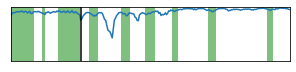

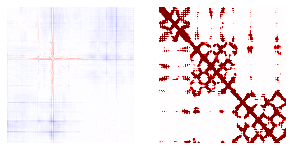

Global lddt (hand calculated): 0.90420
Interface lddt : 0.81111
Interface lddt 2: 0.84845
ChainA lddt : 0.91983
ChainB lddt : 0.90507


In [264]:
digitizations = [-20.0, -15.0, -10.0, -4.0, -2.0, -1.0, -0.5, 0.5, 1.0, 2.0, 4.0, 10.0, 15.0, 20.0]
masses = [digitizations[0]]+[(digitizations[i]+digitizations[i+1])/2 for i in range(len(digitizations)-1)]+[digitizations[-1]]
plt.figure(figsize=(5,1))
plt.plot(range(len(x["lddt"])), x["lddt"])
plt.axvline(b, color="black")
plt.xticks([],[])
plt.yticks([],[])
plt.xlim(-0.5, len(x["lddt"])-0.5)
plt.ylim(0,1)
plt.fill_between(np.arange(len(mask1d)), 0, 1, where=mask1d==1, facecolor='green', alpha=0.5)
plt.show()

plt.figure(figsize=(5,2.5))
plt.subplot(121)
sns.heatmap(np.sum(x["estogram"]*masses, axis=-1), cbar=False, cmap="seismic", vmin=-20, vmax=20)
plt.xticks([],[])
plt.yticks([],[])
plt.subplot(122)
sns.heatmap(x["mask"], cbar=False, cmap="seismic", vmin=-1, vmax=1)
plt.xticks([],[])
plt.yticks([],[])
plt.show()

print("Global lddt (hand calculated): %.5f"%np.mean(get_lddt(x["estogram"], x["mask"])))
print("Interface lddt : %.5f"%np.mean(get_lddt(x["estogram"], np.multiply(imap, x["mask"]))))
print("Interface lddt 2: %.5f"%np.mean(get_lddt(x["estogram"], mask2d)))
print("ChainA lddt : %.5f"%np.mean(get_lddt(x["estogram"], np.multiply(map1, x["mask"]))))
print("ChainB lddt : %.5f"%np.mean(get_lddt(x["estogram"], np.multiply(map2, x["mask"]))))